<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20197772" #@param {type:"string"}
Student_full_name = "Barry Lawton" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [2]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [4]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [5]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Path from my google Drive

Path = '/content/drive/My Drive/Data/ET5003_Etivity_2/'
# house data
train_data = Path + 'house_train.csv'
test_data = Path + 'house_test.csv'
true_price = Path + 'true_price.csv'

# train data
df_train = pd.read_csv(train_data)
print("Training dataset shape : ",df_train.shape)

# test data
df_test = pd.read_csv(test_data)
print("Test dataset shape : ",df_test.shape)

# true price data
df_cost = pd.read_csv(true_price)
print("True Price dataset shape : ",df_cost.shape) 

Training dataset shape :  (2982, 17)
Test dataset shape :  (500, 16)
True Price dataset shape :  (500, 2)


In [8]:
# Make a copy of the origianl dataset just in case I need it later 
df_train_copy = df_train
df_test_copy = df_test
df_cost_copy = df_cost

## Exploratory Data Analysis

In [9]:
df_train.columns

Index(['ad_id', 'area', 'bathrooms', 'beds', 'ber_classification', 'county',
       'description_block', 'environment', 'facility', 'features', 'latitude',
       'longitude', 'no_of_units', 'price', 'property_category',
       'property_type', 'surface'],
      dtype='object')

In [10]:
df_test.columns

Index(['ad_id', 'area', 'bathrooms', 'beds', 'ber_classification', 'county',
       'description_block', 'environment', 'facility', 'features', 'latitude',
       'longitude', 'no_of_units', 'property_category', 'property_type',
       'surface'],
      dtype='object')

In [11]:
df_cost.columns

Index(['Id', 'Expected'], dtype='object')

In [12]:
# Lets make the column names consistent with df_train and df_test
df_cost = df_cost.rename(columns={'Id':'ad_id','Expected':'price'})

In [13]:
df_train.sample(3)

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
298,12104259,Howth,1.0,2.0,E2,Dublin,Sherry FitzGerald present No. 6 Asgard Apartme...,prod,NaN,"Ground floor apartment\nBeach, cliff and sea v...",53.387357,-6.063150,NaN,350000.0,sale,apartment,42.0
2383,12407689,Rathfarnham,3.0,4.0,D1,Dublin,Open View Saturday 7th March 2020 from 2.00 - ...,prod,NaN,GFCH\n,53.274770,-6.300003,NaN,595000.0,sale,detached,135.2
245,12072122,Saggart,4.0,4.0,D2,Dublin,Sherry FitzGerald is delighted to bring Bay Vi...,prod,NaN,Exceptional split level detached family home.\...,53.265258,-6.433161,NaN,725000.0,sale,detached,263.0


In [14]:
df_test.head(3)

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0


In [15]:
df_cost.sample(5)

,ad_id,price
211,12321748,150000.0
141,12390695,215000.0
320,12417061,195000.0
164,12377451,325000.0
50,12357471,975000.0


In [16]:
df_train.dtypes
#df_test.dtypes
#df_cost.dtypes

ad_id                   int64
area                   object
bathrooms             float64
beds                  float64
ber_classification     object
county                 object
description_block      object
environment            object
facility               object
features               object
latitude              float64
longitude             float64
no_of_units           float64
price                 float64
property_category      object
property_type          object
surface               float64
dtype: object

In [17]:
df_train.isna().sum()
#df_test.isna().sum()

ad_id                    0
area                     0
bathrooms               51
beds                    51
ber_classification     677
county                   0
description_block        0
environment              0
facility              2017
features                 0
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

Now lets explore each of the variables, decide what features to extract

## Numerical features

In [18]:
df_train.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


`ad_id`: is an identifier for each advert, this will not be neccessary for training ML model so will be dropped. we will retain it for the test dataset as it will be used to match each example to the corresponding cost in the `df_cost` dataset.         
`bathrooms`: no. of bathrooms in a house. could be a good indicator on a house price, however there is some listings with $0$ bathrooms and others with $18$, so I will need to check for outliers.   
`beds`: no. of beds in a house. this is intuitively a good indicator of a house price, but outliers will need addressed, especially those with $0$.    
`latitude` and `logitude`: Geographical coordinates of a house location. This could alos be a good indicator of a house's price.     
`no_of_units`: Number of units, presumably for bulk buys, there are very few adverts with information on this attribute, so I will drop it.   
`price`: Price on an advert, this is the variable we are trying to predict, not every observation has value for price so these will be dropped.    
`surface`: Surface area of a property, intuitively a good indicator of a properties price, however outliers will need to be investigated.




In [19]:
remove_cols = ['ad_id','no_of_units']
df_train.drop(remove_cols, axis=1, inplace = True)
df_test.drop(remove_cols[1], axis = 1, inplace = True)


#### Removing outliers

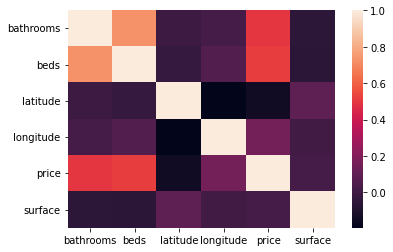

In [20]:
sns.heatmap(df_train.corr())
plt.show()

In [21]:
df_train.describe()

,bathrooms,beds,latitude,longitude,price,surface
count,2931.000000,2931.000000,2982.000000,2982.000000,2.892000e+03,2431.000000
mean,1.998635,2.979188,53.355991,-6.257175,5.323536e+05,318.851787
std,1.291875,1.468408,0.086748,0.141906,5.678148e+05,4389.423136
min,0.000000,0.000000,51.458439,-6.521183,1.999500e+04,3.400000
25%,1.000000,2.000000,53.298929,-6.314064,2.800000e+05,74.100000
50%,2.000000,3.000000,53.345497,-6.252254,3.800000e+05,100.000000
75%,3.000000,4.000000,53.388845,-6.196049,5.750000e+05,142.000000
max,18.000000,27.000000,53.630588,-1.744995,9.995000e+06,182108.539008


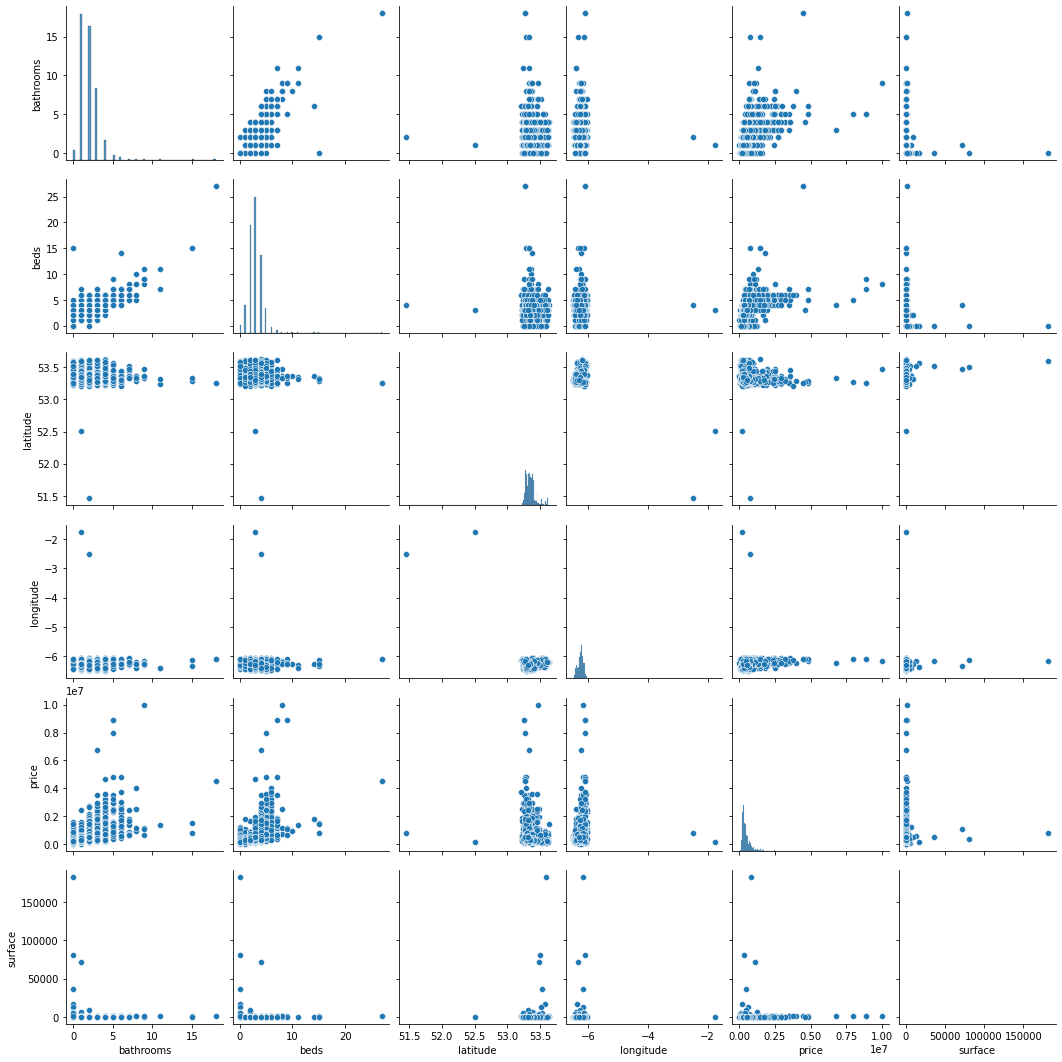

In [22]:
sns.pairplot(df_train)
plt.show()

Looking at the correlation and pairplots of all the remaining numerical features helps to inform what decisions to make when choosing which outliers to ommit from the data.     
`bathrooms`: A house should have at least $1$ bathroom, but also not more than a certain amount, for this I will chose a cut-off of 3 standard deviations above the mean, with $\mu = 1.998635, \sigma = 1.291875$ I choose $6$ as the upper limit.    
`beds`: similarly a house should have at least $1$ bed but not above a certian limit, again I chose a cut-off larger than 3 standard deviations above the mean, with $\mu = 2.979188, \sigma = 1.468408 $, I choose $8$ as the upper limit.  
`latitude`: There appears to be 2 outliers here with a latitude $<
52.5^\circ N$,these will need to be investigated and potientally removed.     
`longitude`:There appears to be 2 outliers here with a longitude $>
-6^\circ W$,these will need to be investigated and potientally removed.     
`price`:     
`surface`: There is a few significant outliers for surface area of property, the vast majority of properties have a surface less than $500$, while there is examples with over $50000$ which would indicate they are not residental properties at all. I have decided to remove any properties which have a surface area above one standard deviation from the mean, above $4710$. 

In [23]:
df_train = df_train[(df_train.beds >0) & (df_train.beds <=6) & (df_train.bathrooms >0) & (df_train.bathrooms <=8) & (df_train.surface <=4710)]
df_test = df_test[(df_test.beds >0) & (df_test.beds <=6) & (df_test.bathrooms >0) & (df_test.bathrooms <=8) & (df_test.surface <=4710)]

In [24]:
# Now investigate the outliers for latitude
df_train[(df_train.latitude <53) ]

,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,price,property_category,property_type,surface
767,Clondalkin,1.0,3.0,NaN,Dublin,RAY COOKE AUCTIONEERS take great pleasure in i...,prod,NaN,None,52.501856,-1.744995,199000.0,sale,semi-detached,79.0


In [25]:
# Now investigate the outliers for latitude
df_train[(df_train.longitude >-6) ]

,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,price,property_category,property_type,surface
767,Clondalkin,1.0,3.0,NaN,Dublin,RAY COOKE AUCTIONEERS take great pleasure in i...,prod,NaN,None,52.501856,-1.744995,199000.0,sale,semi-detached,79.0


A quick search of these coordinates points to an address in Birmingham, UK which is certain not in Clondalkin, Dublin. Therefore I have removed this example. 

In [26]:
df_train.drop(index=767,axis=1,inplace=True)

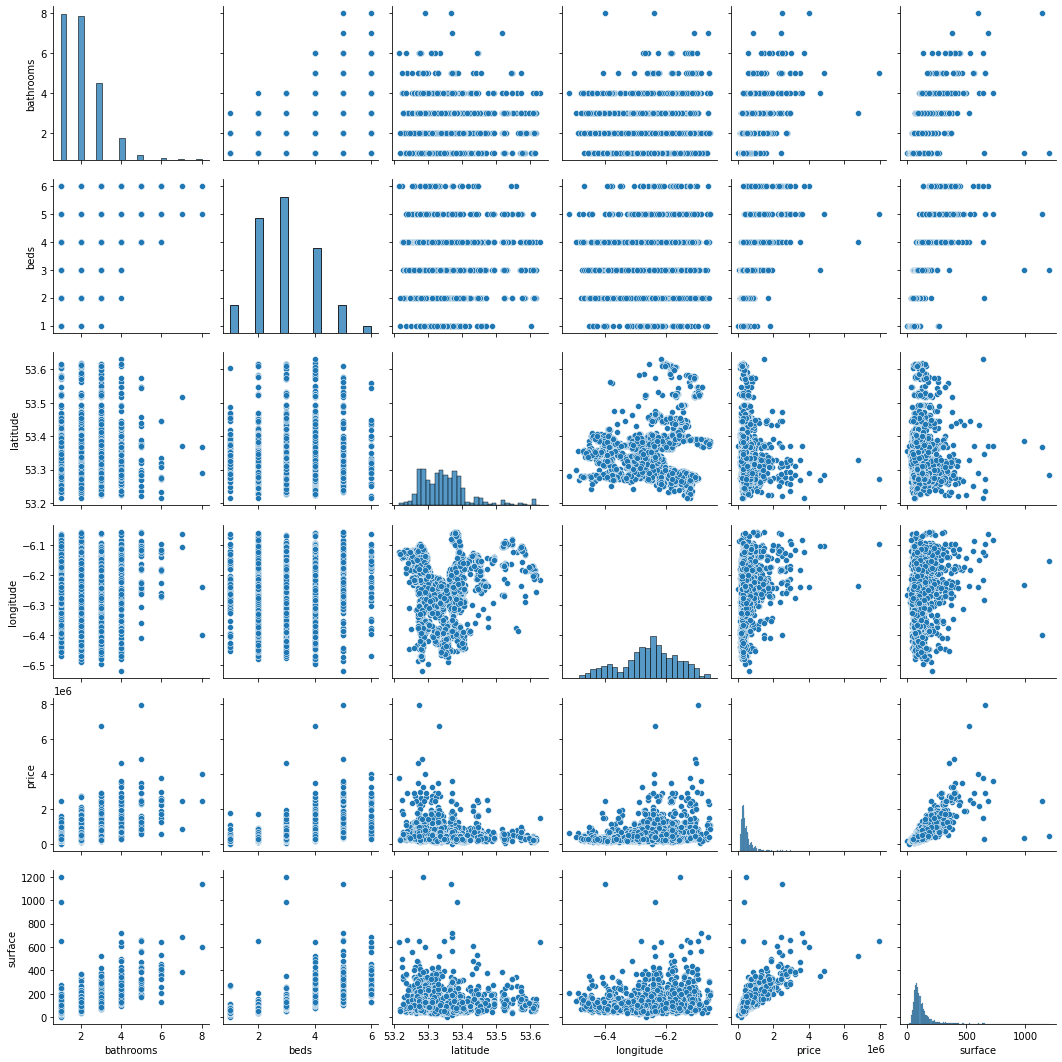

In [27]:
sns.pairplot(df_train)
plt.show()

In [28]:
df_train.isna().sum()

area                     0
bathrooms                0
beds                     0
ber_classification     353
county                   0
description_block        0
environment              0
facility              1511
features                 0
latitude                 0
longitude                0
price                   19
property_category        0
property_type            0
surface                  0
dtype: int64

In [29]:
# Lastly I will remove the 19 cases which are missing a price 
df_train.dropna(subset=['price'],inplace=True)

In [30]:
df_train.shape

(2322, 15)

## Cathegorical features

In [31]:
df_train.describe(include=object)

,area,ber_classification,county,description_block,environment,facility,features,property_category,property_type
count,2322,1973,2322,2322,2322,820,2322,2322,2322
unique,148,16,1,2320,1,33,1609,2,10
top,Rathfarnham,D1,Dublin,Sycamore Grove is a small development of 14 ho...,prod,"Parking,Gas Fired Central Heating",None,sale,apartment
freq,75,252,2322,2,2322,168,708,2316,627


`area`: corresponds to a geographical area by name, could be beneficial to include althought `latitude` and `logitude` should provide the same information.    
`ber_classification`: BER rating a house has, should be a good indicator for the model.     
`county`: County where the property is listed, there is only one observed value $Dublin$ so this feature will be dropped.    
`description_block`: Free text description of the property, seems to be unique for almost every advert. This feature can not be encoded very easily so will be dropped.    
`environment`: this feature has only one observed value so will dropped.     
`facility`: A list of facilities which a property has. There is only $820$ examples with a value here, will need to be investigated further.    
`features`: A free text description of the features a property has. Can not be encoded very easily so this feature will be dropped.
`property_category`: describes the type of advert, as the vast majority of adverts are $sale$ I have decided to drop this feature.     
`property_type`: describes the type of property for sale. This feature should have good potiential to be one-hot encoded.   

In [32]:
remove_cols2 = ['county','description_block','environment','features','property_category']
df_train.drop(remove_cols2, axis=1, inplace = True)
df_test.drop(remove_cols2, axis = 1, inplace = True)

In [33]:
df_train.columns

Index(['area', 'bathrooms', 'beds', 'ber_classification', 'facility',
       'latitude', 'longitude', 'price', 'property_type', 'surface'],
      dtype='object')

In [34]:
for col in df_train.columns:
  if df_train[col].dtypes ==object:
    print("Unique values for ",col," = ",df_train[col].unique(),'\n')

Unique values for  area  =  ['Clonee' 'Clondalkin' 'Howth' 'Castleknock' 'Rathfarnham' 'Carrickmines'
 'Rathmichael' 'Foxrock' 'Dublin 1' 'Balbriggan' 'Lucan' 'Ballsbridge'
 'Sandycove' 'Dalkey' 'Booterstown' 'Rush' 'Cabra' 'Swords' 'Garristown'
 'Drumcondra' 'Skerries' 'Clontarf' 'Ranelagh' 'Dundrum' 'Donnybrook'
 'Malahide' 'Glasnevin' 'Sandyford' 'Dublin 8' 'Palmerstown' 'Finglas'
 'Sandymount' 'Terenure' 'Dublin 2' 'Saggart' 'Mulhuddart' 'Cabinteely'
 'Whitehall' 'Walkinstown' 'Christchurch' 'Blackrock' 'Shankill'
 'Ringsend' 'Churchtown' 'Stepaside' 'Clonskeagh' 'Clongriffin'
 'Dun Laoghaire' 'Ballycullen' 'Ballybrack' 'Clonsilla' 'Mount Merrion'
 'Dublin 7' 'The Ward' 'Sutton' 'Lusk' "Harold's Cross" 'Glenageary'
 'Clarehall' 'Phibsborough' 'Donabate' 'Rathmines' 'Rathgar' 'Portobello'
 'Citywest' 'Baldoyle' 'Killester' 'Navan Road (D7)' 'Killiney' 'Tallaght'
 'Kilmore' 'Loughlinstown' 'Santry' 'Clonshaugh' 'Dublin 4' 'Ballyboughal'
 'Donaghmede' 'East Wall' 'Grand Canal Dock' 'L

As `ber_classification` is an ordinal variable, I create a mapper for this variable.     
Given `property_type` is not an ordinal variable, I will instead one hot encode it.

`area` and `facility` will be dropped. Due to the large amount of unique observations, it would add too many features if they were to be encoded  


In [35]:
remove_cols3 = ['area','facility']
df_train.drop(remove_cols3, axis=1, inplace = True)
df_test.drop(remove_cols3, axis = 1, inplace = True)

In [36]:
ber_mapper = {
    'A1':1,'A2':2,'A3':3,
    'B1':4,'B2':5,'B3':6,
    'C1':7,'C2':8,'C3':9,
    'D1':10,'D2':11,
    'E1':12,'E2':13,
    'F':14,
    'G':15,
    'SINo666of2006exempt':16
}

df_train['ber_classification'] = df_train['ber_classification'].replace(ber_mapper)
df_test['ber_classification'] = df_test['ber_classification'].replace(ber_mapper)

In [37]:
df_train = pd.get_dummies(df_train, columns=['property_type'], drop_first=True)

In [38]:
df_test = pd.get_dummies(df_test, columns=['property_type'], drop_first=True)

In [39]:
print(df_train.isna().sum(),'\n\n', df_test.isna().sum())

bathrooms                         0
beds                              0
ber_classification              349
latitude                          0
longitude                         0
price                             0
surface                           0
property_type_bungalow            0
property_type_detached            0
property_type_duplex              0
property_type_end-of-terrace      0
property_type_semi-detached       0
property_type_site                0
property_type_studio              0
property_type_terraced            0
property_type_townhouse           0
dtype: int64 

 ad_id                            0
bathrooms                        0
beds                             0
ber_classification              47
latitude                         0
longitude                        0
surface                          0
property_type_bungalow           0
property_type_detached           0
property_type_duplex             0
property_type_end-of-terrace     0
property_type_semi-deta

In [40]:
# Lastly I will remove the cases which have ber_classification = NaN
df_train.dropna(subset=['ber_classification'],inplace=True)
df_test.dropna(subset=['ber_classification'],inplace=True)


In [41]:
df_train.describe()

,bathrooms,beds,ber_classification,latitude,longitude,price,surface,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
count,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1.973000e+03,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000
mean,2.022301,2.998479,9.856564,53.349227,-6.252718,5.447949e+05,118.438018,0.027369,0.146984,0.018753,0.077547,0.278763,0.001521,0.000507,0.170299,0.009630
std,1.020336,1.092338,3.156693,0.074342,0.091602,4.590931e+05,82.280837,0.163199,0.354180,0.135686,0.267525,0.448504,0.038974,0.022513,0.375991,0.097684
min,1.000000,1.000000,1.000000,53.215264,-6.521183,1.000000e+05,22.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,8.000000,53.291977,-6.303053,3.000000e+05,73.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,10.000000,53.340011,-6.244568,4.200000e+05,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,4.000000,12.000000,53.380545,-6.184865,6.000000e+05,137.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,6.000000,16.000000,53.630588,-6.054719,7.950000e+06,1195.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
df_test.describe()

,ad_id,bathrooms,beds,ber_classification,latitude,longitude,surface,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
count,4.390000e+02,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.0,439.000000,439.000000,439.000000
mean,1.232104e+07,2.000000,2.945330,9.883827,53.354432,-6.247302,118.102011,0.027335,0.143508,0.018223,0.063781,0.284738,0.0,0.002278,0.177677,0.009112
std,1.369030e+05,1.018101,1.081906,3.113923,0.082464,0.089289,96.105169,0.163243,0.350990,0.133910,0.244642,0.451804,0.0,0.047727,0.382676,0.095127
min,1.149085e+07,1.000000,1.000000,2.000000,53.221348,-6.496987,33.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,1.228731e+07,1.000000,2.000000,8.000000,53.294709,-6.296713,71.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.237954e+07,2.000000,3.000000,10.000000,53.339528,-6.243088,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,1.240568e+07,3.000000,4.000000,12.000000,53.380536,-6.183716,132.195000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000
max,1.242809e+07,8.000000,6.000000,16.000000,53.619775,-6.064874,1462.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


## Training & Test Data

In [43]:
# split data into training and test

from sklearn.model_selection import train_test_split
#X = df_train.drop(['price'], axis=1).values
#y = df_train['price']

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary

#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

### Train dataset

In [62]:
# show first data frame rows 
df_train.head()

,bathrooms,beds,ber_classification,latitude,longitude,price,surface,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
15,3.0,5.0,3.0,53.400454,-6.445730,935000.0,321.0,0,1,0,0,0,0,0,0,0
26,4.0,4.0,3.0,53.316410,-6.385214,485000.0,144.0,0,0,0,0,1,0,0,0,0
27,3.0,5.0,3.0,53.401414,-6.446634,935000.0,321.0,0,1,0,0,0,0,0,0,0
35,5.0,5.0,2.0,53.375377,-6.056749,1475000.0,312.0,0,1,0,0,0,0,0,0,0
38,2.0,2.0,3.0,53.372130,-6.338466,410000.0,83.0,0,0,0,0,0,0,0,0,0


In [63]:
# Generate descriptive statistics
df_train.describe()

,bathrooms,beds,ber_classification,latitude,longitude,price,surface,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
count,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1.973000e+03,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000
mean,2.022301,2.998479,9.856564,53.349227,-6.252718,5.447949e+05,118.438018,0.027369,0.146984,0.018753,0.077547,0.278763,0.001521,0.000507,0.170299,0.009630
std,1.020336,1.092338,3.156693,0.074342,0.091602,4.590931e+05,82.280837,0.163199,0.354180,0.135686,0.267525,0.448504,0.038974,0.022513,0.375991,0.097684
min,1.000000,1.000000,1.000000,53.215264,-6.521183,1.000000e+05,22.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,8.000000,53.291977,-6.303053,3.000000e+05,73.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,10.000000,53.340011,-6.244568,4.200000e+05,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,4.000000,12.000000,53.380545,-6.184865,6.000000e+05,137.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,6.000000,16.000000,53.630588,-6.054719,7.950000e+06,1195.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Test dataset

In [64]:
# show first data frame rows 
df_test.head()

,ad_id,bathrooms,beds,ber_classification,latitude,longitude,surface,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
0,12373510,2.0,4.0,15.0,53.566881,-6.101148,142.0,1,0,0,0,0,0,0,0,0
1,12422623,2.0,3.0,7.0,53.362992,-6.452909,114.0,0,0,0,0,0,0,0,1,0
2,12377408,3.0,4.0,6.0,53.454198,-6.262964,172.0,0,0,0,0,1,0,0,0,0
3,12420093,4.0,3.0,3.0,53.354402,-6.458647,132.4,0,0,0,0,1,0,0,0,0
4,12417338,1.0,3.0,13.0,53.336530,-6.393587,88.0,0,0,0,0,1,0,0,0,0


In [65]:
# Generate descriptive statistics
df_test.describe()

,ad_id,bathrooms,beds,ber_classification,latitude,longitude,surface,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
count,4.390000e+02,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.0,439.000000,439.000000,439.000000
mean,1.232104e+07,2.000000,2.945330,9.883827,53.354432,-6.247302,118.102011,0.027335,0.143508,0.018223,0.063781,0.284738,0.0,0.002278,0.177677,0.009112
std,1.369030e+05,1.018101,1.081906,3.113923,0.082464,0.089289,96.105169,0.163243,0.350990,0.133910,0.244642,0.451804,0.0,0.047727,0.382676,0.095127
min,1.149085e+07,1.000000,1.000000,2.000000,53.221348,-6.496987,33.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,1.228731e+07,1.000000,2.000000,8.000000,53.294709,-6.296713,71.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.237954e+07,2.000000,3.000000,10.000000,53.339528,-6.243088,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,1.240568e+07,3.000000,4.000000,12.000000,53.380536,-6.183716,132.195000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000
max,1.242809e+07,8.000000,6.000000,16.000000,53.619775,-6.064874,1462.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


### Expected Cost dataset

In [66]:
df_cost.head()

,ad_id,price
0,12373510,875000.0
1,12422623,355000.0
2,12377408,440000.0
3,12420093,425000.0
4,12417338,265000.0


In [67]:
# Generate descriptive statistics
df_cost.describe()

,ad_id,price
count,5.000000e+02,5.000000e+02
mean,1.231695e+07,5.810356e+05
std,1.485832e+05,6.009194e+05
min,1.130615e+07,8.500000e+04
25%,1.228617e+07,2.950000e+05
50%,1.237964e+07,4.250000e+05
75%,1.240544e+07,5.950000e+05
max,1.242809e+07,5.750000e+06


# PIECEWISE REGRESSION

## Full Model

In [99]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

#featrain = ['feature_1','feature_2','feature_3','cost']
# dropna: remove missing values
#df_subset_train = dftrain[featrain].dropna(axis=0)

#featest = ['feature_1','feature_2','feature_3']
#df_subset_test  =  dftest[featest].dropna(axis=0)

# cost
#df_cost = df_cost[df_cost.index.isin(df_subset_test.index)]

In [68]:
print('Number of nan in df_subset_train dataset: ',df_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [44]:
X_train = df_train.drop(['price'], axis=1).values
y_train = df_train['price']

X_test = df_test.drop(['ad_id'], axis=1)
# cost
df_cost_check = df_cost[df_cost.index.isin(X_test.index)]
y_test = df_cost_check.drop(['ad_id'],axis = 1).values

In [61]:
Xs_train = X_train.values
ys_train = y_train.values.reshape(-1,1)

Xs_test = X_test.values
ys_test = y_test.values

AttributeError: ignored

In [106]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [107]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 1,660.2


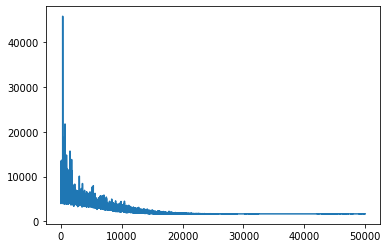

In [108]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [112]:
# samples from the posterior
posterior = approximation.sample(5000)

In [113]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

ValueError: ignored

## Clustering

### Full Model

In [ ]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
# clustering by features 1, 2
ind=[0,1]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

In [ ]:
np.max(ys_train)

### Clusters

In [ ]:
# train clusters



In [ ]:
# test clusters


## Piecewise Model

In [ ]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])



##Simulations

### Only Cluster 0

## Overall

## Test set performance

### PPC on the Test set



# SUMMARY